In [1]:
import matplotlib.pyplot as plt
import pypsa
path ='results/CDRs/base_s_90__Co2L0-3H-T-H-B-I-A-solar+p3-dist1_2050.nc'
n=pypsa.Network(path)

INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [2]:
tCO2_per_MWh = 0.2572
emissions_oil= tCO2_per_MWh*(n.loads[n.loads.index.str.contains("oil")].p_set.sum()*8760/1000000 + 
                             n.loads[n.loads.index.str.contains("kerosene")].p_set.sum()*8760/1000000)
emissions_oil

np.float64(217.78528706356354)

In [3]:
tCO2_per_MWh = 0.2178
emissions_methanol= tCO2_per_MWh*n.loads[n.loads.index.str.contains("methanol")].p_set.sum()*8760/1000000 
emissions_methanol

np.float64(111.44819565877913)

In [12]:
n.links.query("carrier=='EW'").marginal_cost.mean()/(-n.links.query("carrier=='EW'").efficiency.mean())


np.float64(176.00185253107892)

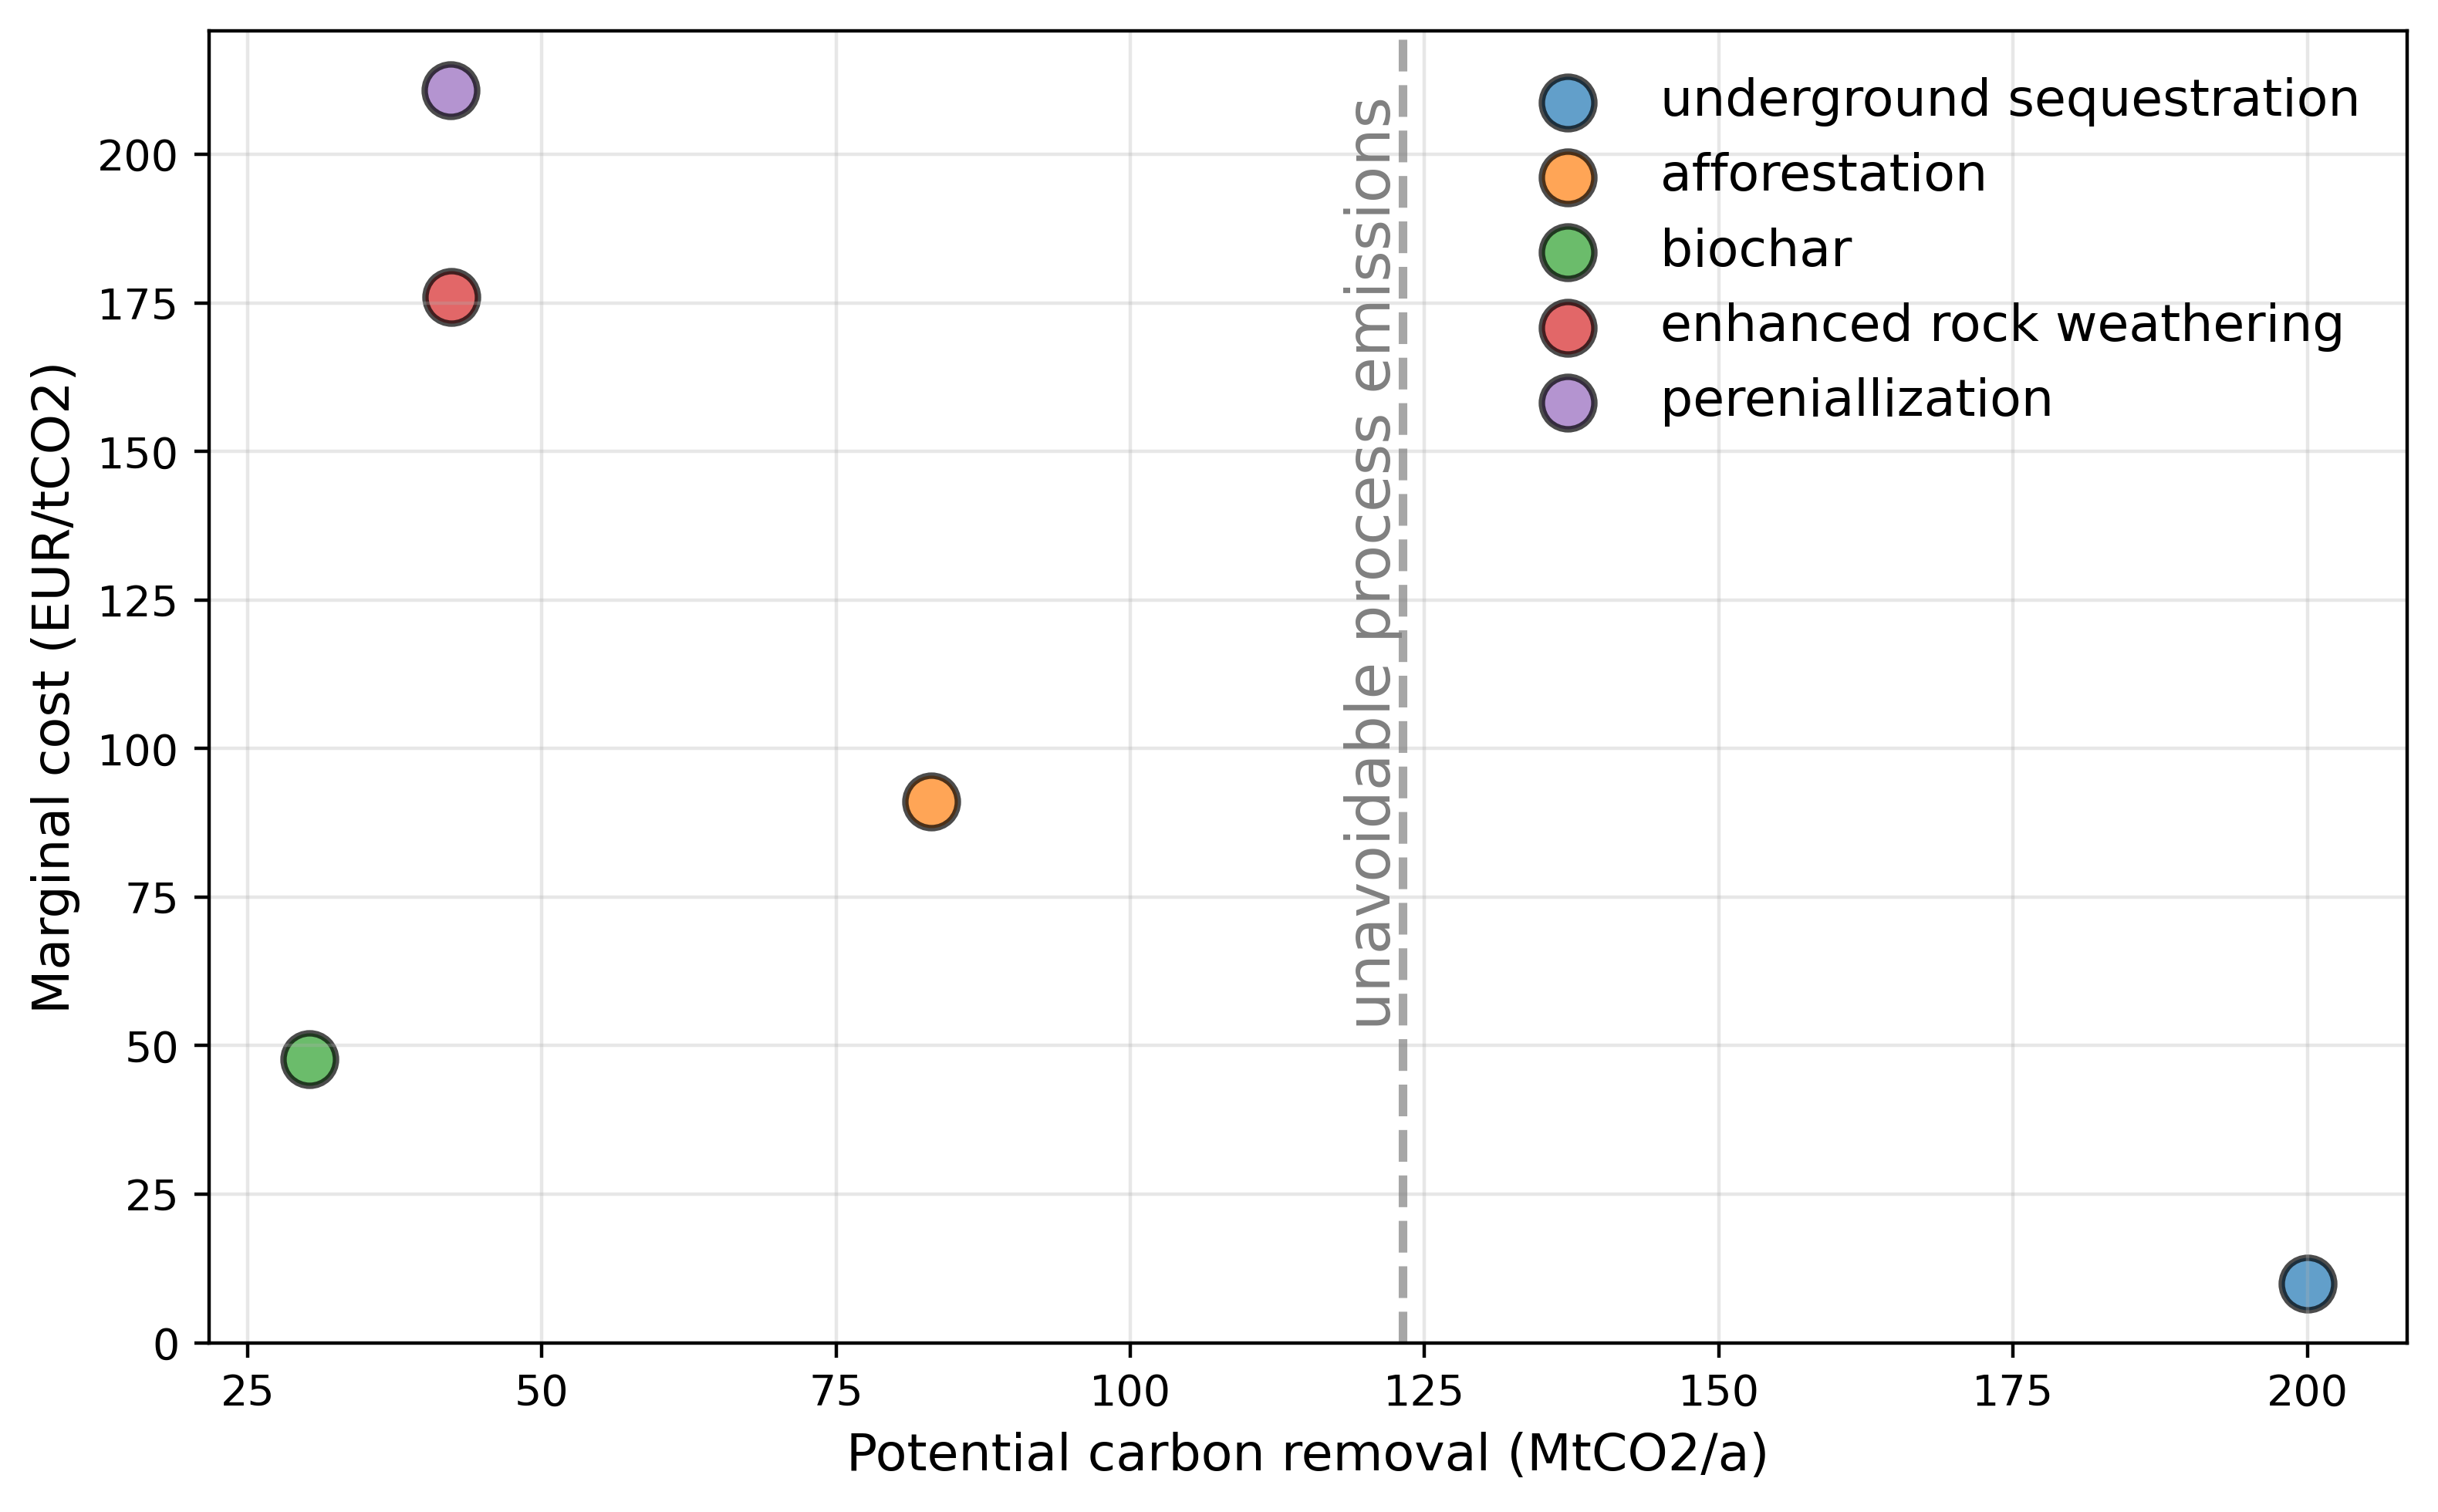

In [17]:

process_emissions = n.loads[n.loads.index.str.contains("process emissions")].p_set.sum()*8760/1000000

# Data for carbon removal strategies
data = {
    "underground sequestration": {"potential": 200, "cost": 10},
    "afforestation": {"potential": n.stores[n.stores.index.str.contains("afforestation")].e_nom_opt.sum()/1000000, 
                      "cost": n.stores[n.stores.index.str.contains("afforestation")].capital_cost.mean()},
    "biochar": {"potential": n.stores[n.stores.index.str.contains("biochar")].e_nom_opt.sum()/1000000, 
                "cost": n.links.query("carrier=='biochar'").marginal_cost.mean()},
    "enhanced rock weathering": {"potential": n.stores[n.stores.index.str.contains("EW")].e_nom_opt.sum()/1000000, 
                                 "cost": n.links.query("carrier=='EW'").marginal_cost.mean()/(-n.links.query("carrier=='EW'").efficiency.mean())},

    "pereniallization": {"potential": n.stores[n.stores.index.str.contains("perennial")].e_nom_opt.sum()/1000000, 
                         "cost": n.links.query("carrier=='perennial'").marginal_cost.mean()}
}


fig, ax = plt.subplots(figsize=(8, 5))


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for (label, values), color in zip(data.items(), colors):
    ax.scatter(values["potential"], values["cost"],
               s=150, alpha=0.7, color=color, label=label, edgecolors='black', linewidth=1.5)


vertical_lines = [
    {"x": -n.loads.query("carrier=='process emissions'").p_set.sum()/1000000*8760
     , "label": "unavoidable process emissions"},
   # {"x": emissions_oil, "label": "fossil emissions aviation and agriculture"},
   # {"x": emissions_methanol, "label": "fossil emissions shipping"}
]

for vline in vertical_lines:
    ax.axvline(x=vline["x"], color='gray', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(vline["x"], ax.get_ylim()[1] * 0.95, vline["label"], 
            rotation=90, verticalalignment='top', horizontalalignment='right',
            fontsize=14, color='gray')

ax.set_xlabel("Potential carbon removal (MtCO2/a)", fontsize=12)
ax.set_ylabel("Marginal cost (EUR/tCO2)", fontsize=12)

ax.legend(loc="best", fontsize=12, framealpha=0.9)

ax.grid(True, alpha=0.3)

plt.savefig("carbon_removal_strategies.png", dpi=300)